In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import minimize

In [3]:
df = pd.read_csv('df.csv')[['tic', 'date', 'close']].rename(columns={'tic': 'Ticker',
                                                                                     'close': 'Price',
                                                                                     'date': 'Date'})

In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.sort_values(by=['Ticker', 'Date'], inplace=True)

In [5]:
df = df[df.Ticker != 'DOW']

In [6]:
df['Returns'] = df.groupby('Ticker')['Price'].pct_change()

In [20]:
window= 21

#### Utils

In [22]:
def portfolio_variance(weights, cov_matrix):
    return weights.dot(cov_matrix).dot(weights.T)

def negative_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    p_var = portfolio_variance(weights, cov_matrix)
    p_ret = weights.dot(returns)
    return -(p_ret - risk_free_rate) / np.sqrt(p_var)

In [71]:
def min_variance_optimization(returns_df, initial_weights):

    # Calculate the covariance matrix
    cov_matrix = returns_df.cov()   

    # Constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 

    # Bounds for weights: can't hold more than 100% of any stock
    bounds = tuple((0, 1) for _ in range(len(initial_weights)))

    # Optimization to
    result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x if result.success else None

def sharpe_ratio_optimization(moving_avg_returns, returns_df, initial_weights, risk_free_rate=0):

    # Calculate the covariance matrix
    cov_matrix = returns_df.cov()   

    # Constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 

    # Bounds for weights: can't hold more than 100% of any stock
    bounds = tuple((0, 1) for _ in range(len(initial_weights)))

    # Optimization to
    result = minimize(negative_sharpe_ratio, initial_weights, args=(moving_avg_returns, cov_matrix, risk_free_rate,),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x if result.success else None

#### Mean Variance Optimization

In [72]:
# Initialize a dictionary to hold the allocations
allocations = {}

# Get unique dates
unique_dates = df['Date'].unique()

# Get unique tickers
tickers = df['Ticker'].unique()

# Initial weights (equal distribution)
initial_weights = np.array([1/len(tickers)] * len(tickers))

df = df[df.Date > pd.Timestamp('2010-12-30')]

for date in unique_dates:

    # Filter the DataFrame for the current date and past year
    start_date = date - pd.DateOffset(years=1)
    past_year_data = df[(df['Date'] > start_date) & (df['Date'] <= date)]
   
    # Skip dates with insufficient data
    if past_year_data['Date'].nunique() < window:
        continue

    # Calculate the moving average of returns for the past year
    moving_avg_returns = past_year_data.groupby('Ticker')['Returns'].mean()

    # Create a DataFrame for the returns
    returns_df = past_year_data.pivot(index='Date', columns='Ticker', values='Returns').dropna()

    # Perform MVO
    optimal_weights = min_variance_optimization(returns_df, initial_weights)
    # optimal_weights = sharpe_ratio_optimization(moving_avg_returns, returns_df, initial_weights, risk_free_rate=0)

    # Store the allocations
    allocations[date] = dict(zip(tickers, optimal_weights))

In [73]:
# Convert allocations to a DataFrame
allocations_df = pd.DataFrame.from_dict(allocations, orient='index')

In [74]:
allocations_df.tail().round(3)

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
2023-02-22,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,...,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034
2023-02-23,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,...,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034
2023-02-24,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,...,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034
2023-02-27,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,...,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034
2023-02-28,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,...,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034,0.034


<br>

### Returns Analysis

In [75]:
df_prices = pd.read_csv('df.csv')[['tic', 'date', 'close']].rename(columns={'tic': 'Ticker',
                                                                                            'close': 'Price',
                                                                                            'date': 'Date'})

In [76]:
df_prices['Date'] = pd.to_datetime(df_prices['Date'], format='%Y-%m-%d')
df_prices['Returns'] = df_prices.groupby('Ticker')['Price'].pct_change()

In [77]:
df_returns = df_prices.pivot(index='Date', columns='Ticker', values='Returns')
df_allocations_aligned = allocations_df.reindex(df_returns.index, method='ffill')
portfolio_returns = (df_returns.shift(-1) * df_allocations_aligned).sum(axis=1)

#### Plot Returns

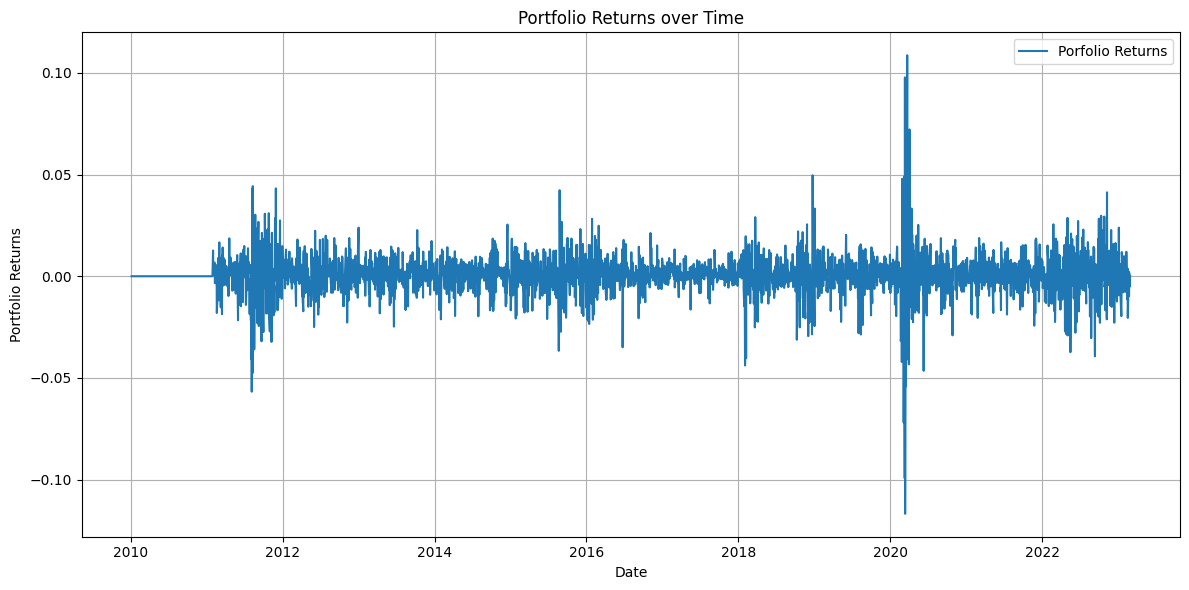

In [78]:
# Create plot
plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns.index, portfolio_returns.values, label='Porfolio Returns', color='#1f77b4', linewidth=1.5)

plt.xlabel('Date')
plt.ylabel('Portfolio Returns')
plt.title('Portfolio Returns over Time')

plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

#### Plot Cumulative Returns

In [79]:
cumulative_returns_from_start_date = (1 + portfolio_returns).cumprod()-1

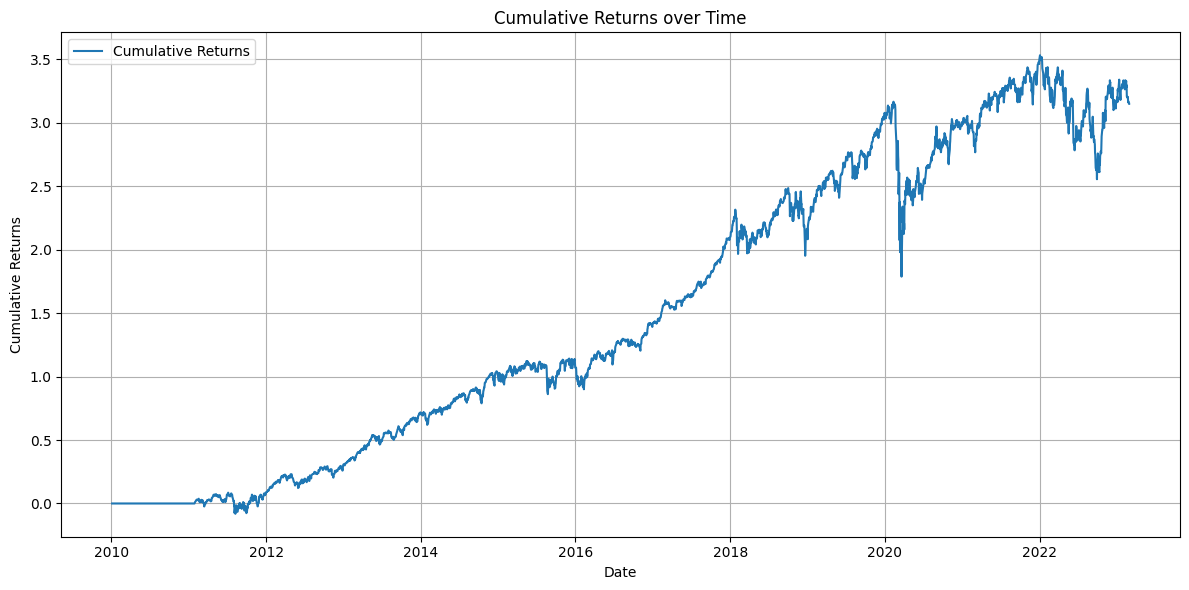

In [80]:
# Create plot
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns_from_start_date.index, cumulative_returns_from_start_date.values, label='Cumulative Returns', color='#1f77b4', linewidth=1.5)

plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns over Time')

plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

#### Save Results

In [81]:
portfolio_returns.to_frame(name='Returns').to_csv('./data/MVO_minvar_returns.csv')

In [339]:
cd Desktop

C:\Users\Windows\Desktop


# visualizations

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [101]:
cum_ret_2016

,averageaction,ensemble,dji,minvar,tangent
date,,,,,
1/4/16,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
1/5/16,1.000011e+06,1.000044e+06,1.000567e+06,9.867256e+05,9.905383e+05
1/6/16,9.990332e+05,9.987382e+05,9.858633e+05,9.656726e+05,9.654358e+05
1/7/16,9.964774e+05,9.958412e+05,9.629808e+05,9.558024e+05,9.577809e+05
1/8/16,9.948623e+05,9.933090e+05,9.532047e+05,9.591375e+05,9.670694e+05
...,...,...,...,...,...
12/23/22,2.324516e+06,2.025177e+06,1.936209e+06,2.011483e+06,2.200994e+06
12/27/22,2.328093e+06,2.024044e+06,1.938403e+06,1.986457e+06,2.177619e+06
12/28/22,2.295126e+06,1.994208e+06,1.917070e+06,2.010091e+06,2.178605e+06


<Axes: xlabel='date'>

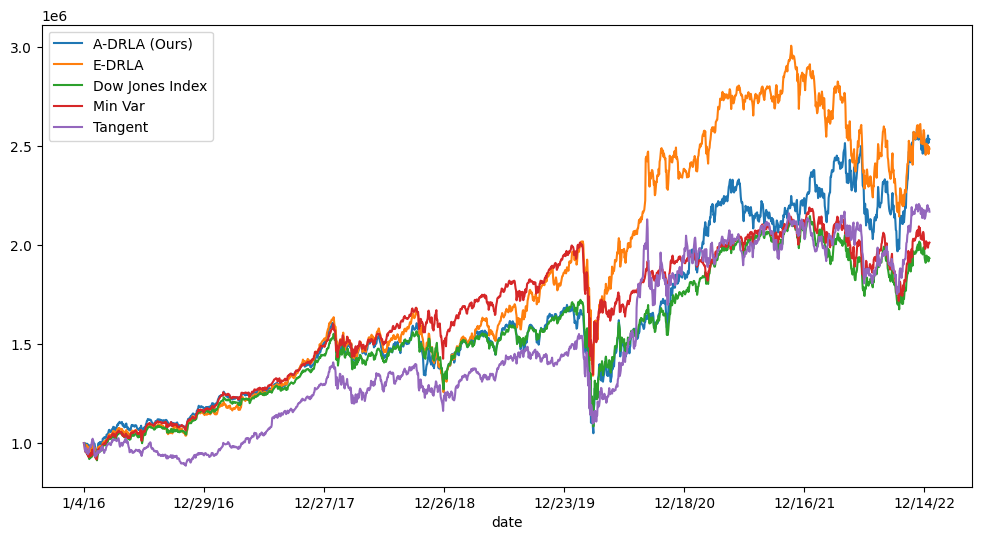

In [3]:
columns = {
    'averageaction': 'A-DRLA (Ours)',
    'ensemble' : 'E-DRLA',
    'dji' : 'Dow Jones Index',
    'minvar' : 'Min Var',
    'tangent' : 'Tangent'
    }
cum_ret_2016 = pd.read_csv('./cum_ret_2016_2022.csv', index_col=0).rename(columns=columns)
cum_ret_2016.plot(figsize=(12, 6))

<Axes: xlabel='date'>

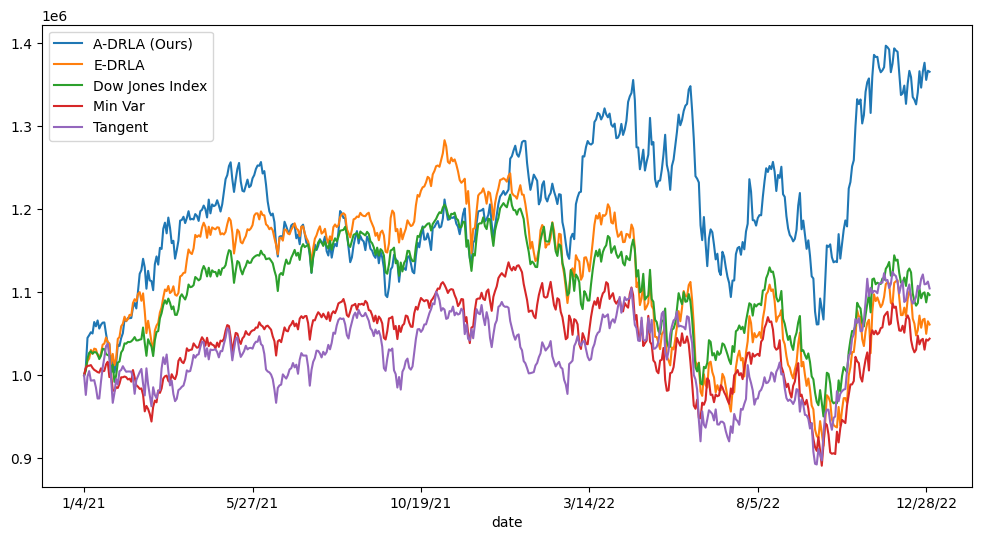

In [4]:
cum_ret_2021 = pd.read_csv('./cum_ret_2021_2022.csv', index_col=0).rename(columns=columns)
cum_ret_2021.plot(figsize=(12, 6))